In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
import random
#from tensorflow import keras
#from tensorflow.keras import layers
import pandas as pd

import keras
import keras.backend
from keras import layers
from keras import models
from keras import optimizers
import keras.utils

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/schubert/.conda/envs/LRP/lib/python3.7/site-packages

1.13.1


## Import data:
Using jetImages_signal.npz and jetImages_bkg.npz to train the neural network and using jetImages_signal_test.npz and jetImages_bkg_test.npz for testing.

In [2]:
grid = 16
# training data : 10,000 signal samples and 10,000 bkg samples
data= np.load('data/ShowJetsData_full.npz')

In [3]:
data_dic={key : data[key]  for key in data.keys()}
n_data=len(data_dic['labels'])
# one-Hot encode the labels 
lal=np.arange(2)
data_dic['labels']=np.array([[ele[0],np.sum(ele[1:])] for ele in data_dic['labels']]).astype(int)
[key for key in data_dic.keys()]

['jetImages',
 'jetPt',
 'jetEta',
 'jetPhi',
 'tau21',
 'chMult',
 'neutMult',
 'phoMult',
 'eleMult',
 'muMult',
 'jetpull',
 'labels']

In [4]:
# features will be loaded into X
features=['jetImages','muMult']
# label into Y
label=['labels']

In [5]:
X=[data_dic[key] for key in features]
Y=[data_dic[key] for key in label]
# Reshape pictures for CNN
X[0]=X[0].reshape(n_data, grid, grid, 1)

Split and Balance Data

In [6]:
random.seed(1)
ind_sig_inb=np.argwhere(Y[0][:,1]==1)[:,0]
ind_bkg=np.argwhere(Y[0][:,0]==1)[:,0]
ind_sig=random.choices(ind_sig_inb,k=len(ind_bkg))

In [7]:
X_sig=[ele[ind_sig] for ele in X]
Y_sig=[ele[ind_sig] for ele in Y]
X_bkg=[ele[ind_bkg] for ele in X]
Y_bkg=[ele[ind_bkg] for ele in Y]

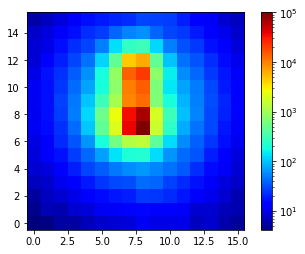

In [8]:
#plot input signal and background
sig_images=0
for ele in X_sig[0]:
    sig_images += ele
bkg_images =0
for ele in X_bkg[0]:
    bkg_images += ele
#signal
display_sig = sig_images.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_sig, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

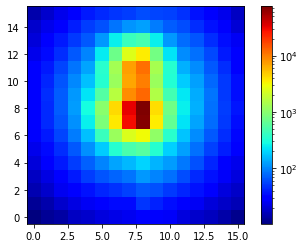

In [9]:
#background
display_bkg = bkg_images.reshape(grid,grid)
plt.grid(False)
plt.imshow(display_bkg, interpolation='nearest', origin='low', cmap = 'jet', norm=LogNorm())
plt.colorbar()
plt.show()

### Split into train and test set and balance numbers

balance data

In [10]:
print(len(X_sig[0]))
print(len(X_bkg[0]))

496341
496341


split into train and test set

In [11]:
# Give train test split percentage
split=0.9

In [12]:
random.seed(2)
ind_sig=np.random.permutation(len(X_sig[0]))
ind_bkg=np.random.permutation(len(X_bkg[0]))
ind_sig_train=ind_sig[:int(split*len(X_sig[0]))]
ind_sig_test=ind_sig[int(split*len(X_sig[0])):]
ind_bkg_train=ind_sig[:int(split*len(X_sig[0]))]
ind_bkg_test=ind_sig[int(split*len(X_sig[0])):]

In [13]:
X_train=[np.concatenate((X_sig[i][ind_sig_train],X_bkg[i][ind_bkg_train]),axis=0) for i in range(len(X_sig))]
Y_train=[np.concatenate((Y_sig[i][ind_sig_train],Y_bkg[i][ind_bkg_train]),axis=0) for i in range(len(Y_sig))]
X_test=[np.concatenate((X_sig[i][ind_sig_test],X_bkg[i][ind_bkg_test]),axis=0) for i in range(len(X_sig))]
Y_test=[np.concatenate((Y_sig[i][ind_sig_test],Y_bkg[i][ind_bkg_test]),axis=0) for i in range(len(Y_sig))]

Reshape all features

In [14]:
dim=[1 if ele[0].shape==() else ele[0].shape[0] for ele in X_train]
for i in range(1,len(X_train)):
    X_train[i]=X_train[i].reshape(len(X_train[i]),dim[i])
for i in range(1,len(X_test)):
    X_test[i]=X_test[i].reshape(len(X_test[i]),dim[i])

Normalize data

In [15]:
minn=np.min(X_train[i])
maxx=np.max(X_train[i])
X_train[0]=(X_train[0]-minn)/(maxx-minn)

In [16]:
for i in range(1,len(X_train)):
    minn=np.min(X_train[i],axis=0)
    maxx=np.max(X_train[i],axis=0)
    X_train[i]=(X_train[i]-minn)/(maxx-minn)

In [17]:
minn=np.min(X_test[i])
maxx=np.max(X_test[i])
X_test[0]=(X_test[0]-minn)/(maxx-minn)

In [18]:
for i in range(1,len(X_test)):
    minn=np.min(X_test[i],axis=0)
    maxx=np.max(X_test[i],axis=0)
    X_test[i]=(X_test[i]-minn)/(maxx-minn)

### Build DNN:

In [19]:
def build_model():
    input2=[layers.Input(shape=(len(X_train[i][0]),)) for i in range(1,len(X_train))]
    input1 = layers.Input(shape = (grid, grid,1))
    x = layers.Conv2D(32, (5, 5), activation='relu',padding='same')(input1)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x1 = layers.Flatten()(x)
    x = layers.concatenate(inputs = [x1]+input2,axis=-1)
    x = layers.Dense(256, activation='relu')(x)
    output = layers.Dense(2, activation='softmax')(x)
    model = models.Model(inputs=[input1] +input2, outputs=output)
    opt=keras.optimizers.Adam(lr=0.0005,beta_1=0.9, beta_2=0.9, amsgrad=False)
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['binary_crossentropy', 'accuracy'])
    return model

Initialize model:

In [20]:
circleCNN = build_model()

Instructions for updating:
Colocations handled automatically by placer.


Test model's prediction $before$ training:

In [21]:
X_batch =[ele[:200] for ele in X_train]
Y_batch =[ele[:200] for ele in Y_train]
example_result = circleCNN.predict(x = X_batch)
results = circleCNN.evaluate(x = X_batch, y =Y_batch )
print(example_result)
print(results)

200/200 [==============================] - 0s 326us/step
[[0.4999397  0.50006026]
 [0.49994835 0.5000516 ]
 [0.49993455 0.5000654 ]
 [0.49986634 0.50013375]
 [0.49991956 0.50008047]
 [0.49982947 0.50017047]
 [0.5001153  0.4998847 ]
 [0.49996033 0.50003964]
 [0.49993014 0.50006986]
 [0.49990788 0.5000921 ]
 [0.4999388  0.50006115]
 [0.4998914  0.50010854]
 [0.50002253 0.49997753]
 [0.49986145 0.5001386 ]
 [0.50007993 0.49992007]
 [0.49986565 0.5001344 ]
 [0.49979958 0.50020045]
 [0.5000188  0.49998125]
 [0.50004613 0.49995393]
 [0.49867922 0.5013207 ]
 [0.5001324  0.49986768]
 [0.49992567 0.5000743 ]
 [0.49994752 0.50005245]
 [0.4997707  0.50022936]
 [0.49970227 0.5002977 ]
 [0.5000331  0.49996698]
 [0.49834785 0.5016521 ]
 [0.4998858  0.50011414]
 [0.49816158 0.5018384 ]
 [0.49999318 0.5000068 ]
 [0.499794   0.50020593]
 [0.49996197 0.500038  ]
 [0.49988446 0.5001155 ]
 [0.4999629  0.50003713]
 [0.4997856  0.5002144 ]
 [0.49818113 0.5018189 ]
 [0.49994746 0.5000526 ]
 [0.49993747 0.500

Now train! (warning: if building CNN, computer tends to get loud)

In [22]:
#circleCNN = keras.models.load_model('model/CNN_full.h2')

In [29]:
circleCNN.save("model/CNN_full.h3")

In [25]:
# class PrintDot(keras.model.save(filepath)callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0:
#             print('')
#         print('.', end='')
    
checkpoint_path = "model/CNN_full.h2"
if not os.path.exists("model"):
    os.mkdir("model")

# Create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
#                                                  save_best_only=True,
#                                                  verbose=1)
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', 
                                   verbose=1, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)    
EPOCHS = 30
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
history = circleCNN.fit(
  X_train, Y_train,
  epochs=EPOCHS, validation_split = 0.2, verbose = 1,
  callbacks=[early_stop, model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 714729 samples, validate on 178683 samples
Epoch 1/30
714729/714729 [==============================] - 660s 923us/step - loss: 0.5324 - binary_crossentropy: 0.5324 - acc: 0.7264 - val_loss: 0.6715 - val_binary_crossentropy: 0.6715 - val_acc: 0.6961

Epoch 00001: val_loss improved from inf to 0.67146, saving model to model/CNN_full.h2
Epoch 2/30
714729/714729 [==============================] - 713s 998us/step - loss: 0.5115 - binary_crossentropy: 0.5115 - acc: 0.7440 - val_loss: 0.6375 - val_binary_crossentropy: 0.6375 - val_acc: 0.7154

Epoch 00002: val_loss improved from 0.67146 to 0.63748, saving model to model/CNN_full.h2
Epoch 3/30
714729/714729 [==============================] - 731s 1ms/step - loss: 0.5086 - binary_crossentropy: 0.5086 - acc: 0.7464 - val_loss: 0.7204 - val_binary_crossentropy: 0.7204 - val_acc: 0.6802

Epoch 00003: val_loss did not improve from 0.63748
Epoch 4/30
714729/714729 [============================

Now make a plot that shows the pregression of accuracy through each training epoch.

In [25]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch
  
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['binary'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_squared_error'],
#            label = 'Val Error')
#   plt.ylim([0,100])
#   plt.legend()
#   plt.show()

# plot_history(history)

Load best weights.

In [30]:
!ls model
best_model = keras.models.load_model('model/CNN_full.h3')
best_model.summary()
results = best_model.evaluate(X_test, Y_test)
print(results)

CNN_full.h1  CNN_full.h2  CNN_full.h3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 32)   9248        conv2d_2[0][0]                   
_______________________________________________________________________

Evaluate the performance of our DNN! Plot predictions vs. true values (the line is predictions vs. predicitons).

In [31]:
predict = best_model.predict(X_test)

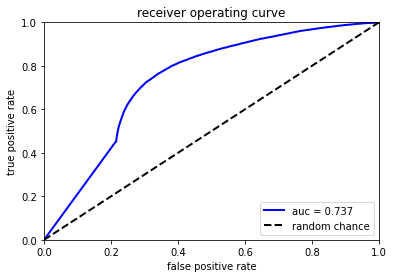

In [32]:
# Plot ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test[0][:,1], predict[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, color='b', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()

In [53]:
# hist, bin_edges = np.histogram(predict[:int(len(predict)/2)])
# hist_, bin_edges_ = np.histogram(predict[:-int(len((predict)-1)/2)])
# plt.hist([predict[:int(len(predict)/2)].flatten(), predict[int(len(predict)/2)-1:-1].flatten()] ,
#          color = ['blue', 'red'], histtype = 'step', label = ['signal', 'background'])
# plt.legend()
# plt.yscale('log')
# plt.show()